In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import torch.nn as nn

In [8]:
df = pd.read_csv('complaints.csv')
le_cat = LabelEncoder().fit(df['category'])
le_urg = LabelEncoder().fit(df['urgency'])
df['cat'] = le_cat.transform(df['category'])
df['urg'] = le_urg.transform(df['urgency'])
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['cat'], random_state=42)

In [9]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

class ComplaintsDataset(Dataset):
    def __init__(self, texts, cats, urgs):
        self.enc = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.cats, self.urgs = cats, urgs
    def __len__(self):
        return len(self.cats)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item['cat'] = torch.tensor(self.cats[i])
        item['urg'] = torch.tensor(self.urgs[i])
        return item

train_dl = DataLoader(ComplaintsDataset(train_df.complaint_text.tolist(),
                                         train_df.cat.tolist(),
                                         train_df.urg.tolist()),
                      batch_size=16, shuffle=True)
val_dl = DataLoader(ComplaintsDataset(val_df.complaint_text.tolist(),
                                       val_df.cat.tolist(),
                                       val_df.urg.tolist()),
                    batch_size=16)


In [10]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = AutoModel.from_pretrained('distilbert-base-uncased')
        h = self.enc.config.hidden_size
        self.drop = nn.Dropout(0.3)
        self.head_cat = nn.Linear(h, len(le_cat.classes_))
        self.head_urg = nn.Linear(h, len(le_urg.classes_))
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        x = self.enc(input_ids, attention_mask=attention_mask)[0][:,0]
        x = self.drop(x)
        return self.head_cat(x), self.head_urg(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-5)
sched = get_linear_schedule_with_warmup(opt, num_warmup_steps=0,
                                        num_training_steps=len(train_dl)*3)
crit = nn.CrossEntropyLoss()


In [11]:
for epoch in range(10):
    model.train()
    for b in train_dl:
        opt.zero_grad()
        ids, mask = b['input_ids'].to(device), b['attention_mask'].to(device)
        logits_cat, logits_urg = model(ids, mask)
        loss = crit(logits_cat, b['cat'].to(device)) + crit(logits_urg, b['urg'].to(device))
        loss.backward()
        opt.step()
        sched.step()
    model.eval()
    y_true_cat, y_pred_cat, y_true_urg, y_pred_urg = [], [], [], []
    with torch.no_grad():
        for b in val_dl:
            ids, mask = b['input_ids'].to(device), b['attention_mask'].to(device)
            lc, lu = model(ids, mask)
            y_true_cat += b['cat'].tolist()
            y_pred_cat += torch.argmax(lc,1).cpu().tolist()
            y_true_urg += b['urg'].tolist()
            y_pred_urg += torch.argmax(lu,1).cpu().tolist()
    print(classification_report(y_true_cat, y_pred_cat, target_names=le_cat.classes_))
    print(classification_report(y_true_urg, y_pred_urg, target_names=le_urg.classes_))

                 precision    recall  f1-score   support

       Academic       0.92      0.91      0.92        92
    Campus Life       0.96      0.80      0.88        87
Dining Services       0.98      1.00      0.99        50
     Facilities       0.89      0.94      0.92        89
  Financial Aid       0.94      0.97      0.95        87
        Housing       0.97      0.97      0.97        89
     IT Support       0.91      0.97      0.94       106

       accuracy                           0.94       600
      macro avg       0.94      0.94      0.94       600
   weighted avg       0.94      0.94      0.93       600

              precision    recall  f1-score   support

    Critical       0.87      0.41      0.55        64
        High       0.56      0.24      0.34       121
         Low       0.61      0.45      0.52       196
      Medium       0.45      0.76      0.56       219

    accuracy                           0.52       600
   macro avg       0.62      0.46      0.49 

In [12]:
torch.save({'state': model.state_dict(),
            'le_cat': le_cat, 'le_urg': le_urg},
           'model.pt')

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()
y_true_g, y_pred_g, y_true_p, y_pred_p = [], [], [], []
with torch.no_grad():
    for b in val_dl:
        ids, mask = b['input_ids'].to(device), b['attention_mask'].to(device)
        lg, lp = model(ids, mask)
        y_true_g += b['cat'].tolist()
        y_pred_g += lg.argmax(1).cpu().tolist()
        y_true_p += b['urg'].tolist()
        y_pred_p += lp.argmax(1).cpu().tolist()

print(classification_report(y_true_g, y_pred_g, target_names=le_cat.classes_))
print(classification_report(y_true_p, y_pred_p, target_names=le_urg.classes_))

                 precision    recall  f1-score   support

       Academic       0.97      0.93      0.95        92
    Campus Life       0.94      0.84      0.88        87
Dining Services       0.98      0.98      0.98        50
     Facilities       0.88      0.96      0.91        89
  Financial Aid       0.97      0.97      0.97        87
        Housing       0.99      0.97      0.98        89
     IT Support       0.92      0.97      0.94       106

       accuracy                           0.94       600
      macro avg       0.95      0.94      0.95       600
   weighted avg       0.94      0.94      0.94       600

              precision    recall  f1-score   support

    Critical       0.74      0.58      0.65        64
        High       0.54      0.35      0.42       121
         Low       0.67      0.69      0.68       196
      Medium       0.52      0.63      0.57       219

    accuracy                           0.59       600
   macro avg       0.62      0.56      0.58 

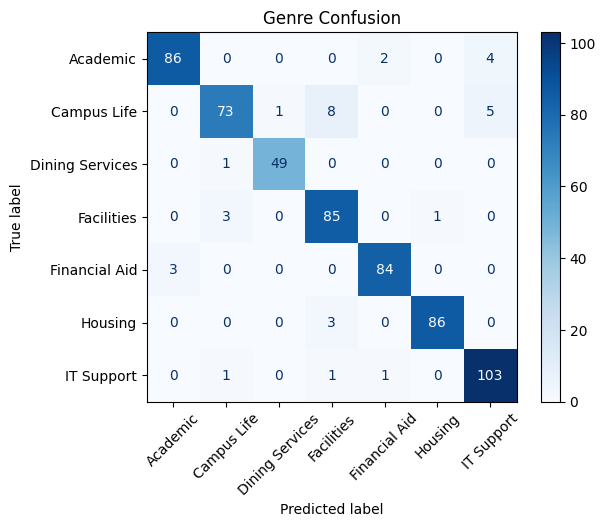

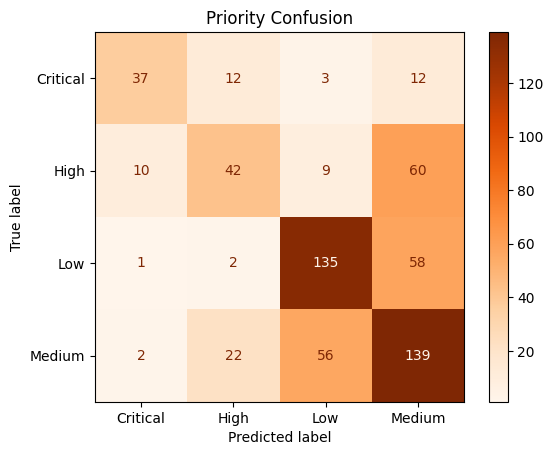

In [18]:
cm_g = confusion_matrix(y_true_g, y_pred_g)
disp_g = ConfusionMatrixDisplay(cm_g, display_labels=le_cat.classes_)
disp_g.plot(cmap='Blues', xticks_rotation=45)
plt.title('Genre Confusion')
plt.show()

cm_p = confusion_matrix(y_true_p, y_pred_p)
disp_p = ConfusionMatrixDisplay(cm_p, display_labels=le_urg.classes_)
disp_p.plot(cmap='Oranges')
plt.title('Priority Confusion')
plt.show()

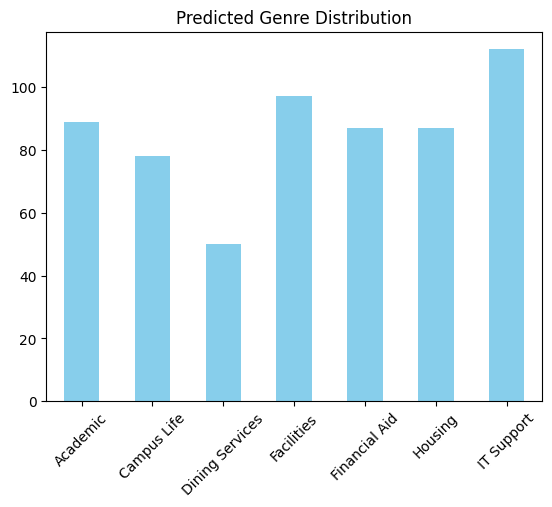

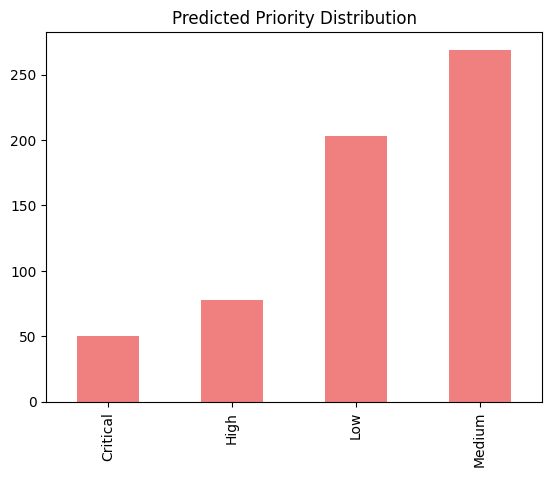

In [19]:
pd.Series(y_pred_g).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xticks(range(len(le_cat.classes_)), le_cat.classes_, rotation=45)
plt.title('Predicted Genre Distribution')
plt.show()

pd.Series(y_pred_p).value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xticks(range(len(le_urg.classes_)), le_urg.classes_)
plt.title('Predicted Priority Distribution')
plt.show()

In [13]:
# inference
from torch.serialization import safe_globals
from sklearn.preprocessing import LabelEncoder

with safe_globals([LabelEncoder]):
    ck = torch.load('model.pt', map_location=device, weights_only=False)

model.load_state_dict(ck['state'])
model.to(device).eval()
le_cat, le_urg = ck['le_cat'], ck['le_urg']

def predict(text):
    e = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    lc, lu = model(**e)
    return (
        le_cat.inverse_transform([lc.argmax(1).item()])[0],
        le_urg.inverse_transform([lu.argmax(1).item()])[0]
    )

In [14]:
texts = [
    "The WiFi in the engineering building drops every 10 minutes during lectures—it's impossible to follow online demos.",
    "My roommate blasts music past midnight every night and RA hasn't responded to my reports.",
    "I never received my midterm grade for CS 201 and the deadline to contest is tomorrow.",
    "The new dining hall menu has no vegan or gluten‑free options even though I requested accommodations.",
    "Lab equipment in Chem 305 is broken and TA said repairs aren't scheduled until next month—this delays our project.",
    "Student portal won't let me register for two required courses that have no time conflicts."
]

for t in texts:
    genre, priority = predict(t)
    print(f"text: {t}\n→ genre: {genre}, priority: {priority}\n")

text: The WiFi in the engineering building drops every 10 minutes during lectures—it's impossible to follow online demos.
→ genre: IT Support, priority: Medium

text: My roommate blasts music past midnight every night and RA hasn't responded to my reports.
→ genre: Housing, priority: Medium

text: I never received my midterm grade for CS 201 and the deadline to contest is tomorrow.
→ genre: Academic, priority: High

text: The new dining hall menu has no vegan or gluten‑free options even though I requested accommodations.
→ genre: Dining Services, priority: Low

text: Lab equipment in Chem 305 is broken and TA said repairs aren't scheduled until next month—this delays our project.
→ genre: Academic, priority: High

text: Student portal won't let me register for two required courses that have no time conflicts.
→ genre: IT Support, priority: Medium

